# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import MultipleLocator

## GW150914

Download data

In [3]:
# from gwosc.locate import get_event_urls
# urls = get_event_urls('GW190521')
# urls

In [4]:
# !wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
# !wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

Set some parameters of GW150914

In [26]:
input = dict(model_list = [(2, 2, 0, 'p'), (3,2,0,'p')], #l, m, n, prograde/retrograde
             # trucation time (geocenter, in second)
             t_init = 1242442967.445+2.0*1e-3, #Ref time from: https://arxiv.org/pdf/2105.05238.pdf p9
             # length of the analysis segment (in second)
             segment_length = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # sky localization
             ra = 3.5, dec = 0.73, #taken from https://github.com/gwastro/BH-Spectroscopy-GW190521/tree/main -> configuration files -> [static params]
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [27]:
fit.import_ligo_data('H-H1_GWOSC_16KHZ_R1-1242442952-32.hdf5')
fit.import_ligo_data('L-L1_GWOSC_16KHZ_R1-1242442952-32.hdf5')

Perform time alignment across detectors

In [28]:
fit.detector_alignment()
fit.start_times # This is different to Capano et al. p9

{'H1': 1242442967.4278975, 'L1': 1242442967.4262729}

Condition data 

In [29]:
fit.condition_data('original_data', **input)

Cholesky-decomposition of the covariance matrix 

In [30]:
fit.compute_acfs('original_data')
fit.cholesky_decomposition()

## Likelihood as a function of mass and spin

Sampling remnant mass and spin

In [31]:
delta_mass = 2.0
delta_chi = 0.03
massspace = np.arange(100, 500, delta_mass)
chispace = np.arange(-0., 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

Interate over the samplings

In [32]:
fit.first_index()
likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)

In [33]:
projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, delta_mass, delta_chi)

Plot 2d contours

In [34]:
Capano_et_al = [328, 0.86, [[38], [33]], [[0.11], [0.06]]]
GWTC2 = [163.9, 0.03,  [[23.5], [39.5]], [[0.39], [0.32]]]

Text(0.5, 1.0, 'GW190521, t_init + 2ms, $\\mathcal{F}_{220} + \\mathcal{F}_{221}$')

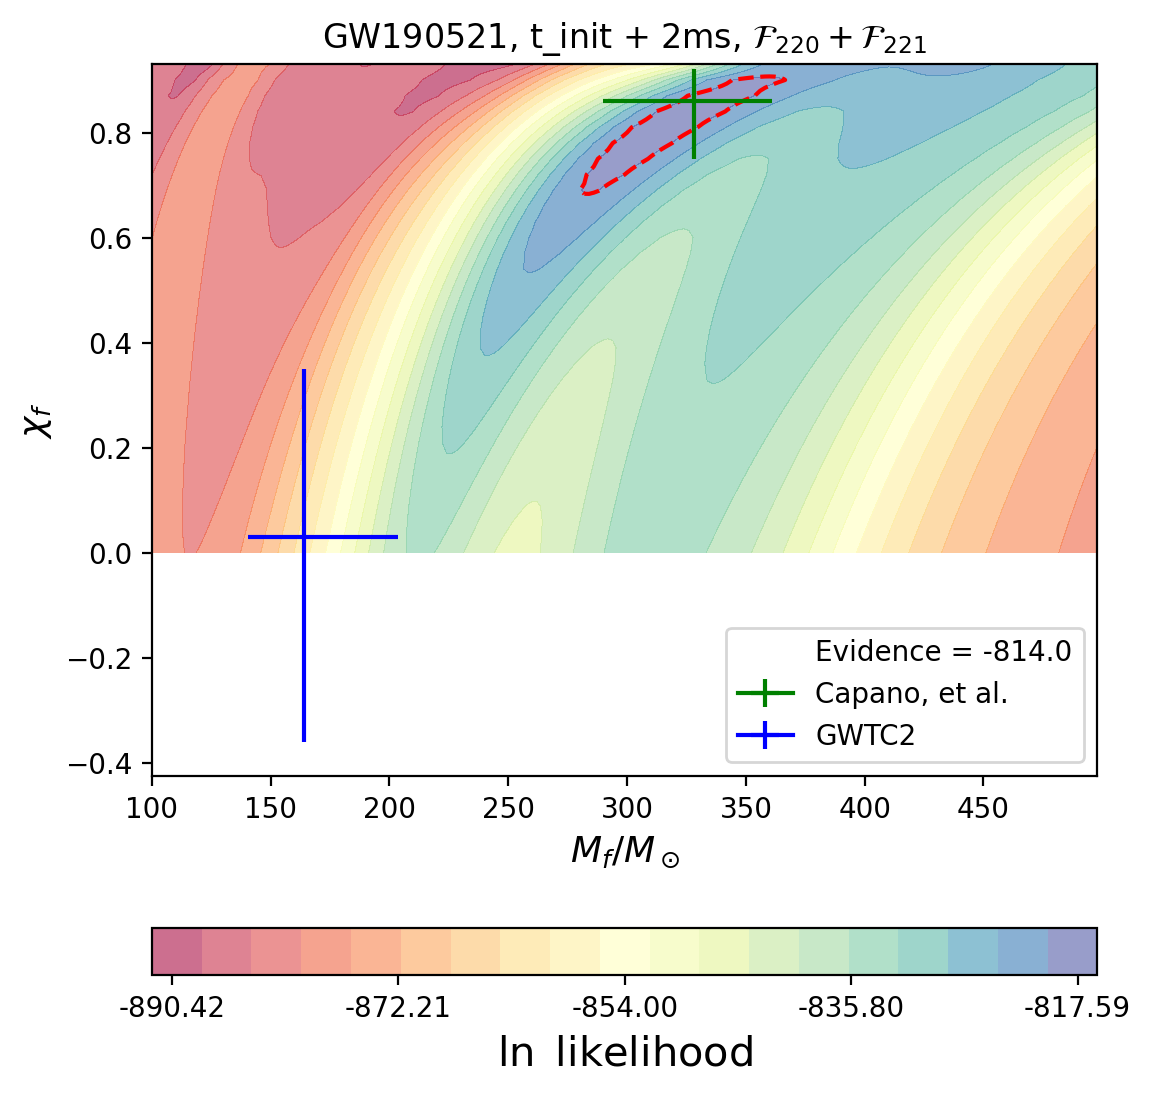

In [35]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.errorbar(x=Capano_et_al[0], y=Capano_et_al[1], xerr=Capano_et_al[2], yerr=Capano_et_al[3], 
           c='g', label='Capano, et al.')
ax.errorbar(x=GWTC2[0], y=GWTC2[1], xerr=GWTC2[2], yerr=GWTC2[3],  
           c='b', label='GWTC2')
ax.plot(np.NaN, np.NaN, '-', color='none', label='Evidence = %.1F' % evidence)


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.legend(loc = 'lower right')

ax.set_title(r'GW190521, t_init + 2ms, $\mathcal{F}_{220} + \mathcal{F}_{221}$')

With 1D side plots

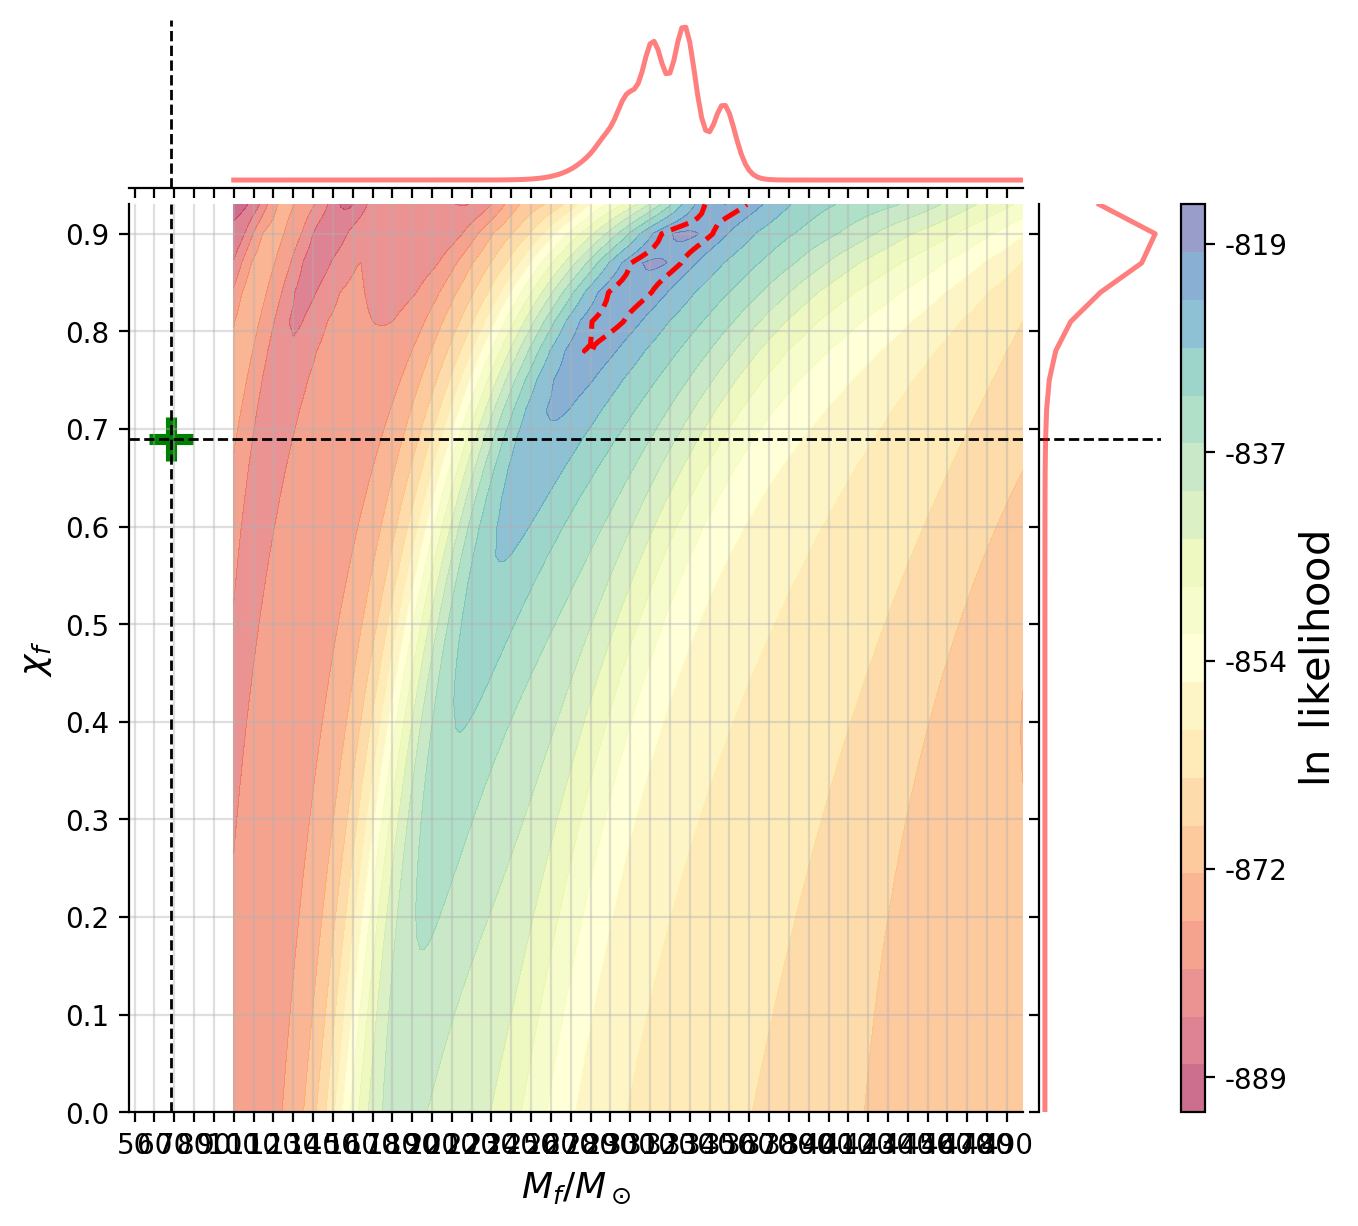

In [15]:
g = sns.JointGrid(ratio=5,space=0.1)

# 2D
contours=g.ax_joint.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
g.ax_joint.contour(contours, levels=[credible_region], linewidths=1.8,
                   linestyles='--', colors='red')
g.ax_joint.xaxis.set_major_locator(MultipleLocator(10))
g.ax_joint.yaxis.set_major_locator(MultipleLocator(0.1))
g.ax_joint.scatter(x=68.5, y=0.69, s=255, marker='+', 
                   c='g', linewidths=4, label='IMR')
g.ax_joint.axvline(68.5, ls='--', lw=1, c='k')
g.ax_joint.axhline(0.69, ls='--', lw=1, c='k')
g.ax_joint.set_xlabel(r'$M_f/M_\odot$', fontsize=13)
g.ax_joint.set_ylabel(r'$\chi_f$', fontsize=13)
g.ax_joint.grid(alpha=0.4)

# 1D side plots 
g.ax_marg_x.axvline(68.5, ls='--', lw=1, c='k')
g.ax_marg_x.plot(massspace, projected_mass, color='r', lw=1.8, alpha=0.5)

g.ax_marg_y.axhline(0.69, ls='--', lw=1, c='k')
g.ax_marg_y.plot(projected_chi, chispace, color='r',lw=1.8,alpha=0.5)

# coloarbar
divider = make_axes_locatable(g.ax_marg_y)
cax = divider.append_axes('right', size='20%', pad=0.1)
cbar=g.fig.colorbar(contours, cax=cax, orientation="vertical", format='%3.0f', ax=g.ax_marg_y)
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))